In [1]:
%load_ext autoreload
%autoreload 2

# Placeholder graphs
Graphs with dummy data

# Resources
- https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08

In [2]:
import os
import pandas as pd
import numpy as np

from scipy import stats

import multiprocessing as mp
import itertools
import tqdm

import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from libphase.scripts.simpoint import simpoint

import seaborn as sns

style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
sns.set(context="talk", style="ticks", font_scale=1.5)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

# Chapter 2: Challenges and opportunities

## 1. Use fixed, non-overlapping windows

### Simple example

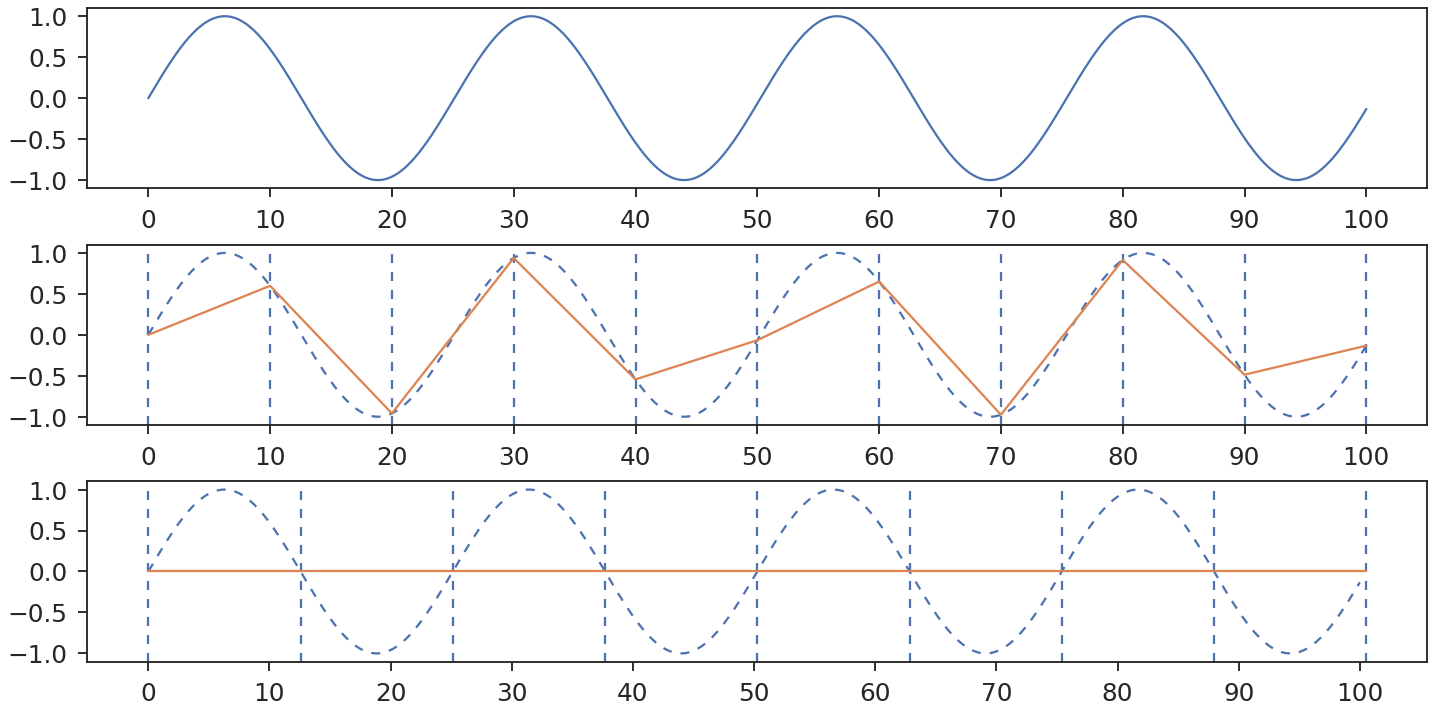

In [3]:
xs = np.linspace(0, 100, 1001)
sin = np.sin((xs + 10) * (np.pi) / 10)
sin = np.sin(xs / 4)

dashes = (4, 4, 4, 4)

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

plt.subplot(3, 1, 1)
plt.plot(xs, sin)
plt.xticks(np.linspace(0, 100, 11))
plt.yticks(np.linspace(-1, 1, 5))

plt.subplot(3, 1, 2)
plt.plot(xs, sin, dashes=dashes)
plt.xticks(np.linspace(0, 100, 11))
plt.yticks(np.linspace(-1, 1, 5))

for i in np.linspace(0, 100, 11):
    plt.axvline(x=i, ymin=0, ymax=1, dashes=dashes)

plt.plot(np.linspace(0, 100, 11), np.sin(np.linspace(0, 100, 11) / 4))

plt.subplot(3, 1, 3)
plt.plot(xs, sin, dashes=dashes)
plt.xticks(np.linspace(0, 100, 11))
plt.yticks(np.linspace(-1, 1, 5))
for i in np.arange(0, 101, 4 * np.pi):
    plt.axvline(x=i, ymin=0, ymax=1, dashes=dashes)
    
plt.plot(np.arange(0, 101, 4 * np.pi), np.sin(np.arange(0, 101, 4 * np.pi)))

fig.tight_layout(pad=1.0)

### Shifting / scaling

In [4]:
# Units of millions
path = "../tmp/spec_1m/500.perlbench_r.1.bbv"

In [672]:
def shiftscale(path, shift = 0, scale = 1):
    print("{}: {} {}".format(path, shift, scale))
    mpath = path.replace(".bbv", ".{}.{}.bbv".format(shift, scale))
    out = open(mpath, "w")
    with open(path, "r") as f:
        nline = 0
        interval = {}

        for line in f:

            # Skip all lines that don't begin with T
            if line[0] != "T":
                continue

            nline += 1

            # Shift by certain number of intervals
            if nline <= shift:
                continue

            # Start new window
            if (nline - shift - 1) % scale == 0:
                if len(interval.keys()) > 0:
                    # write
                    to_write = "T" + " ".join([":{}:{}".format(key, interval[key]) for key in interval])
                    out.write(to_write)
                    out.write("\n")

                # Create a new interval
                interval = {}

            bbv = line[1:].split()
            for bb in bbv:
                key, val = bb.split(":")[1:]
                if key in interval:
                    interval[key] += int(val)
                else:
                    interval[key] = int(val)
        
        # Write last line
        if len(interval.keys()) > 0:
            # write
            to_write = "T" + " ".join([":{}:{}".format(key, interval[key]) for key in interval])
            out.write(to_write)
            out.write("\n")

In [684]:
bbv_paths = !find "../tmp/bbv" | grep "500.perlbench_r.1" | grep "100.bbv"

In [688]:
def find_bbv_dim(paths):
    result = {}
    for path in paths:
        print(path)
#         result[path] = set()
        result[path] = 0
        with open(path, "r") as f:
            for line in f:
                if line[0] != "T":
                    continue
                bbv = line[1:].split()
                for bb in bbv:
                    key, val = bb.split(":")[1:]
                    if int(key) > result[path]:
                        result[path] = int(key)
#                     result[path].add(key)
#         print(len(result[path]))
        print(result[path])

In [689]:
find_bbv_dim(bbv_paths)

../tmp/bbv/500.perlbench_r.1.20.100.bbv
29406
../tmp/bbv/500.perlbench_r.1.70.100.bbv
29284
../tmp/bbv/500.perlbench_r.1.30.100.bbv
29424
../tmp/bbv/500.perlbench_r.1.90.100.bbv
29358
../tmp/bbv/500.perlbench_r.1.100.100.bbv
29364
../tmp/bbv/500.perlbench_r.1.60.100.bbv
29284
../tmp/bbv/500.perlbench_r.1.10.100.bbv
29388
../tmp/bbv/500.perlbench_r.1.80.100.bbv
29284
../tmp/bbv/500.perlbench_r.1.40.100.bbv
29434
../tmp/bbv/500.perlbench_r.1.0.100.bbv
29884
../tmp/bbv/500.perlbench_r.1.50.100.bbv
29284


In [698]:
def append_dim(paths, dim):
    for path in paths:
        with open(path, "a") as f:
            f.write("T:{}:1\n".format(dim))

In [699]:
bbv_paths = !find "../tmp/bbv" | grep "500.perlbench_r.1" | grep "100.bbv" | grep -v "\.0\.100"

In [700]:
bbv_paths

['../tmp/bbv/500.perlbench_r.1.20.100.bbv',
 '../tmp/bbv/500.perlbench_r.1.70.100.bbv',
 '../tmp/bbv/500.perlbench_r.1.30.100.bbv',
 '../tmp/bbv/500.perlbench_r.1.90.100.bbv',
 '../tmp/bbv/500.perlbench_r.1.100.100.bbv',
 '../tmp/bbv/500.perlbench_r.1.60.100.bbv',
 '../tmp/bbv/500.perlbench_r.1.10.100.bbv',
 '../tmp/bbv/500.perlbench_r.1.80.100.bbv',
 '../tmp/bbv/500.perlbench_r.1.40.100.bbv',
 '../tmp/bbv/500.perlbench_r.1.50.100.bbv']

In [701]:
append_dim(bbv_paths, 29884)

In [644]:
class SimPoint(object):
    def __init__(self, benchmark, directory, shift=0, scale=1):
        self.benchmark = benchmark
        self.directory = os.path.abspath(directory)
        self.shift = shift
        self.scale = scale
        
        # Load simpoint id and weight
        self.simpoint_meta = pd.read_csv(os.path.join(self.directory, "out.simpoints"), sep=" ", names=["vid", "sid"])
        weights = pd.read_csv(os.path.join(self.directory, "out.weights"), sep=" ", names=["weight", "sid"])
        self.simpoint_meta = self.simpoint_meta.merge(weights)
        
        # Load simpoint coordinates; strip off weight [0], dimension [1], and NaN [17]
        self.simpoint_coords = pd.read_csv(os.path.join(self.directory, "out.centres"), sep=" ", skiprows=1, header=None)
        self.simpoint_coords = self.simpoint_coords.drop(columns=[0, 1, 17])
        self.simpoint_coords.columns = range(15)
        
        # Load frequency vector labels
        self.fv_meta = pd.read_csv(os.path.join(self.directory, "out.labels"), sep=" ", names=["sid", "distance"])
        self.fv_meta["period"] = self.fv_meta.index
        
        # Load projected frequency vectors
        self.fv_coords = pd.read_csv(os.path.join(self.directory, "out.vectors"), sep=" ", skiprows=1, header=None)
        self.fv_coords = self.fv_coords.drop(columns=[0, 1, 17])
        self.fv_coords.columns = range(15)
        
        # Expand according to scale
        self.expanded_fv_meta = self.fv_meta.loc[self.fv_meta.index.repeat(scale)].reset_index(drop=True)
        self.expanded_fv_meta["period"] = self.expanded_fv_meta.index + shift
        
        self.expanded_fv_coords = self.fv_coords.loc[self.fv_coords.index.repeat(scale)].reset_index(drop=True)
        self.expanded_fv_coords["period"] = self.expanded_fv_coords.index + shift
        
        self.expanded_fv = self.expanded_fv_meta.merge(self.simpoint_coords, left_on="sid", right_index=True).sort_index()
        
        print(self.directory)
    
    # Run validation on inputs
    def validate(self):
        # Verify label and distances match computed distance between simpoint and fv coordinates
        data = pd.concat([self.fv_meta, self.fv_coords], axis=1).merge(self.simpoint_coords, left_on="sid", right_index=True).sort_index()
        x = data[["{}_x".format(i) for i in range(15)]]
        y = data[["{}_y".format(i) for i in range(15)]]
        d = np.sqrt(np.square(np.array(x) - np.array(y)).sum(axis=1))
        
        return np.allclose(d, data.distance)
    
    def distance(self, other):
        merged = self.expanded_fv.merge(other.expanded_fv, on="period")
        x = merged[["{}_x".format(i) for i in range(15)]]
        y = merged[["{}_y".format(i) for i in range(15)]]
        d = np.sqrt(np.square(np.array(x) - np.array(y)).sum(axis=1))
        result = merged[["period"]]
        result["distance"] = d
        
        return result
    
    # delta True: find distance between centers
    # delta False: match class and plot
    def plot(self, others=None, delta=True):
        fig, ax = plt.subplots()
        fig.set_size_inches(20, 10)

        if not delta:
            ax.plot(self.expanded_fv_meta.period, self.expanded_fv_meta.sid)
        
        if others is not None:
            for other in others:
                other.match(self)
                fv_meta = other.expanded_fv_meta.merge(other.simpoint_meta, how="left")
                if not delta:
                    ax.plot(fv_meta.period, fv_meta["mid.{}.{}".format(self.shift, self.scale)])
                else:
                    distance = self.distance(other)
                    ax.plot(distance.period[other.scale:], distance.distance[other.scale:], label="{}.{}".format(other.shift, other.scale))
                    
        plt.legend()
    
    def match(self, other):
        matched = pd.DataFrame(index=self.simpoint_meta.index, columns=["mid"])
        col = "mid.{}.{}".format(other.shift, other.scale)
        for i in range(self.simpoint_meta.shape[0]):
            matched.mid.iloc[i] = np.square(other.simpoint_coords - self.simpoint_coords.iloc[i]).sum(axis=1).idxmin()
        
        self.simpoint_meta[col] = matched.mid

In [673]:
shifts = np.arange(10, 110, 10)
scales = [100]

In [674]:
shifts

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [675]:
args = itertools.product([path], shifts, scales)

In [676]:
args, num_jobs = itertools.tee(args)
num_jobs = len(list(num_jobs))

In [677]:
num_jobs

10

In [678]:
def runner(args):
    return shiftscale(*args)

In [679]:
# with mp.Pool(processes=mp.cpu_count()) as pool:
#     result = list(tqdm.tqdm(pool.imap(runner, args), total=num_jobs))

  0%|          | 0/10 [00:00<?, ?it/s]

../tmp/spec_1m/500.perlbench_r.1.bbv: 10 100
../tmp/spec_1m/500.perlbench_r.1.bbv: 30 100
../tmp/spec_1m/500.perlbench_r.1.bbv: 20 100
../tmp/spec_1m/500.perlbench_r.1.bbv: 40 100
../tmp/spec_1m/500.perlbench_r.1.bbv: 50 100
../tmp/spec_1m/500.perlbench_r.1.bbv: 60 100
../tmp/spec_1m/500.perlbench_r.1.bbv: 70 100
../tmp/spec_1m/500.perlbench_r.1.bbv: 80 100
../tmp/spec_1m/500.perlbench_r.1.bbv: 100 100
../tmp/spec_1m/500.perlbench_r.1.bbv: 90 100


100%|██████████| 10/10 [19:22<00:00, 116.20s/it] 


In [680]:
bbv_paths = !find "../tmp/bbv" | grep "500.perlbench_r.1" | grep "100.bbv"

In [681]:
bbv_paths.sort()

['../tmp/bbv/500.perlbench_r.1.0.100.bbv',
 '../tmp/bbv/500.perlbench_r.1.10.100.bbv',
 '../tmp/bbv/500.perlbench_r.1.100.100.bbv',
 '../tmp/bbv/500.perlbench_r.1.20.100.bbv',
 '../tmp/bbv/500.perlbench_r.1.30.100.bbv',
 '../tmp/bbv/500.perlbench_r.1.40.100.bbv',
 '../tmp/bbv/500.perlbench_r.1.50.100.bbv',
 '../tmp/bbv/500.perlbench_r.1.60.100.bbv',
 '../tmp/bbv/500.perlbench_r.1.70.100.bbv',
 '../tmp/bbv/500.perlbench_r.1.80.100.bbv',
 '../tmp/bbv/500.perlbench_r.1.90.100.bbv']

In [682]:
simpoint('../tmp/bbv/500.perlbench_r.1.0.100.bbv', None, 30, None, True, "{}.{}".format(0, 100), True, True, False, None)

{'bbv_file': '../tmp/bbv/500.perlbench_r.1.0.100.bbv', 'k': None, 'max_k': 30, 'proj_matrix': None, 'variable_length': True, 'output_dir': '0.100', 'save_proj_matrix': True, 'verbose': True, 'quiet': False, 'args': None}
/home/dsuo/libphase/tmp/bbv/0.100
Command:  /home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.0.100.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/0.100/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/0.100/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/0.100/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/0.100/out.labels -saveVectorsTxtFmt /home/dsuo/libphase/tmp/bbv/0.100/out.vectors -saveProjMatrixTxtFmt /home/dsuo/libphase/tmp/bbv/0.100/out.proj_matrix -k search -maxK 30 -fixedLength off
Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.0.100.bbv -saveSimpoints /h

(b'Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.0.100.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/0.100/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/0.100/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/0.100/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/0.100/out.labels -saveVectorsTxtFmt /home/dsuo/libphase/tmp/bbv/0.100/out.vectors -saveProjMatrixTxtFmt /home/dsuo/libphase/tmp/bbv/0.100/out.proj_matrix -k search -maxK 30 -fixedLength off"\nUsing these options (*** indicates user-specified option):\n*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.0.100.bbv\n*** -k : search\n    -iters : 100\n    -dim : 15\n*** -maxK : 30\n    -numInitSeeds : 5\n    -coveragePct : 1\n    -bicThreshold : 0.9\n    -saveAll : false\n    -initkm : samp\n*** -saveLabels : /home/dsuo/libphase/tmp/bbv/0.100/out.labels\n*** -saveSimpoints : /home/dsuo/libphase/tmp/bbv/0.100/out

In [702]:
for bbv_path in bbv_paths.sort():
    shift, scale = bbv_path.split("/")[-1].split(".")[3:5]
    simpoint(bbv_path, None, 30, "../tmp/bbv/0.100/out.proj_matrix", False, "{}.{}".format(shift, scale), True, True, False, None)

{'bbv_file': '../tmp/bbv/500.perlbench_r.1.10.100.bbv', 'k': None, 'max_k': 30, 'proj_matrix': '../tmp/bbv/0.100/out.proj_matrix', 'variable_length': False, 'output_dir': '10.100', 'save_proj_matrix': True, 'verbose': True, 'quiet': False, 'args': None}
/home/dsuo/libphase/tmp/bbv/10.100
Command:  /home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.10.100.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/10.100/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/10.100/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/10.100/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/10.100/out.labels -saveVectorsTxtFmt /home/dsuo/libphase/tmp/bbv/10.100/out.vectors -loadProjMatrixTxtFmt ../tmp/bbv/0.100/out.proj_matrix -saveProjMatrixTxtFmt /home/dsuo/libphase/tmp/bbv/10.100/out.proj_matrix -k search -maxK 30
Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bi

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.100.100.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/100.100/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/100.100/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/100.100/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/100.100/out.labels -saveVectorsTxtFmt /home/dsuo/libphase/tmp/bbv/100.100/out.vectors -loadProjMatrixTxtFmt ../tmp/bbv/0.100/out.proj_matrix -saveProjMatrixTxtFmt /home/dsuo/libphase/tmp/bbv/100.100/out.proj_matrix -k search -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.100.100.bbv
*** -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/100.100/out.labels
*** -saveSimpoints

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.20.100.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/20.100/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/20.100/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/20.100/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/20.100/out.labels -saveVectorsTxtFmt /home/dsuo/libphase/tmp/bbv/20.100/out.vectors -loadProjMatrixTxtFmt ../tmp/bbv/0.100/out.proj_matrix -saveProjMatrixTxtFmt /home/dsuo/libphase/tmp/bbv/20.100/out.proj_matrix -k search -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.20.100.bbv
*** -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/20.100/out.labels
*** -saveSimpoints : /home/

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.30.100.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/30.100/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/30.100/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/30.100/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/30.100/out.labels -saveVectorsTxtFmt /home/dsuo/libphase/tmp/bbv/30.100/out.vectors -loadProjMatrixTxtFmt ../tmp/bbv/0.100/out.proj_matrix -saveProjMatrixTxtFmt /home/dsuo/libphase/tmp/bbv/30.100/out.proj_matrix -k search -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.30.100.bbv
*** -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/30.100/out.labels
*** -saveSimpoints : /home/

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.40.100.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/40.100/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/40.100/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/40.100/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/40.100/out.labels -saveVectorsTxtFmt /home/dsuo/libphase/tmp/bbv/40.100/out.vectors -loadProjMatrixTxtFmt ../tmp/bbv/0.100/out.proj_matrix -saveProjMatrixTxtFmt /home/dsuo/libphase/tmp/bbv/40.100/out.proj_matrix -k search -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.40.100.bbv
*** -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/40.100/out.labels
*** -saveSimpoints : /home/

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.50.100.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/50.100/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/50.100/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/50.100/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/50.100/out.labels -saveVectorsTxtFmt /home/dsuo/libphase/tmp/bbv/50.100/out.vectors -loadProjMatrixTxtFmt ../tmp/bbv/0.100/out.proj_matrix -saveProjMatrixTxtFmt /home/dsuo/libphase/tmp/bbv/50.100/out.proj_matrix -k search -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.50.100.bbv
*** -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/50.100/out.labels
*** -saveSimpoints : /home/

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.60.100.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/60.100/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/60.100/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/60.100/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/60.100/out.labels -saveVectorsTxtFmt /home/dsuo/libphase/tmp/bbv/60.100/out.vectors -loadProjMatrixTxtFmt ../tmp/bbv/0.100/out.proj_matrix -saveProjMatrixTxtFmt /home/dsuo/libphase/tmp/bbv/60.100/out.proj_matrix -k search -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.60.100.bbv
*** -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/60.100/out.labels
*** -saveSimpoints : /home/

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.70.100.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/70.100/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/70.100/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/70.100/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/70.100/out.labels -saveVectorsTxtFmt /home/dsuo/libphase/tmp/bbv/70.100/out.vectors -loadProjMatrixTxtFmt ../tmp/bbv/0.100/out.proj_matrix -saveProjMatrixTxtFmt /home/dsuo/libphase/tmp/bbv/70.100/out.proj_matrix -k search -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.70.100.bbv
*** -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/70.100/out.labels
*** -saveSimpoints : /home/

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.80.100.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/80.100/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/80.100/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/80.100/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/80.100/out.labels -saveVectorsTxtFmt /home/dsuo/libphase/tmp/bbv/80.100/out.vectors -loadProjMatrixTxtFmt ../tmp/bbv/0.100/out.proj_matrix -saveProjMatrixTxtFmt /home/dsuo/libphase/tmp/bbv/80.100/out.proj_matrix -k search -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.80.100.bbv
*** -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/80.100/out.labels
*** -saveSimpoints : /home/

Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.90.100.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/90.100/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/90.100/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/90.100/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/90.100/out.labels -saveVectorsTxtFmt /home/dsuo/libphase/tmp/bbv/90.100/out.vectors -loadProjMatrixTxtFmt ../tmp/bbv/0.100/out.proj_matrix -saveProjMatrixTxtFmt /home/dsuo/libphase/tmp/bbv/90.100/out.proj_matrix -k search -maxK 30"
Using these options (*** indicates user-specified option):
*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.90.100.bbv
*** -k : search
    -iters : 100
    -dim : 15
*** -maxK : 30
    -numInitSeeds : 5
    -coveragePct : 1
    -bicThreshold : 0.9
    -saveAll : false
    -initkm : samp
*** -saveLabels : /home/dsuo/libphase/tmp/bbv/90.100/out.labels
*** -saveSimpoints : /home/

In [494]:
results = []
proj_matrix = np.array(data["10000.10000"].proj_matrix).transpose()

for i in range(1000000):
    if i % 10000 == 0:
        print(i)
        
    tmp = np.random.rand(data["10000.10000"].proj_matrix.shape[0], 1)
    tmp = tmp / tmp.sum()
    vec1 = np.matmul(proj_matrix, tmp)
    tmp = np.random.rand(data["10000.10000"].proj_matrix.shape[0], 1)
    tmp = tmp / tmp.sum()
    vec2 = np.matmul(proj_matrix, tmp)
    
    results.append(np.linalg.norm(vec1 - vec2))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000


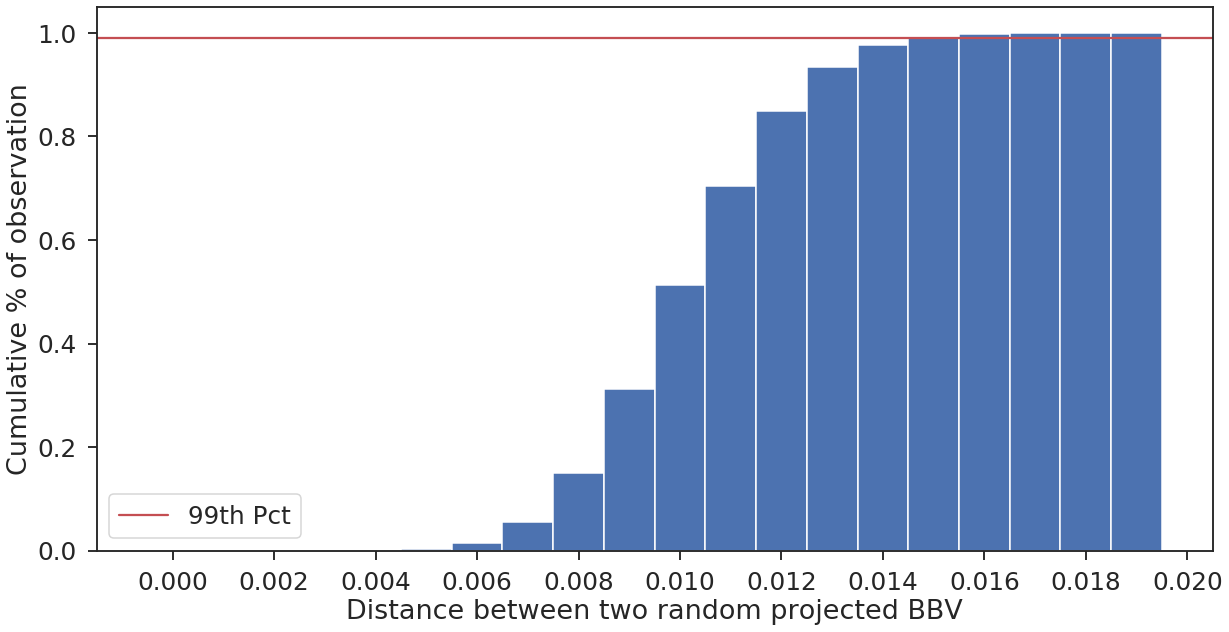

In [637]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.hist(results, bins=(np.linspace(0, 0.02, 21) - 0.0005), density=True, cumulative=True)
plt.xticks(np.linspace(0, 0.02, 11))
# plt.xticks(range(20))
plt.xlabel("Distance between two random projected BBV")
plt.ylabel("Cumulative % of observation")
plt.axhline(0.99, color="r", label="99th Pct")
plt.legend()

In [626]:
np.linspace(0, 0.02, 21)

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 ])

In [645]:
shift_data = {}
for i in np.arange(0, 11000, 1000):
    shift = i
    scale = 10000
    name = "{}.{}".format(shift, scale)
    print("Loading {}".format(name))
    shift_data[name] = SimPoint("500.perlbench_r.1", "../tmp/bbv/{}".format(name), shift=shift, scale=scale)

Loading 0.10000
/home/dsuo/libphase/tmp/bbv/0.10000
Loading 1000.10000
/home/dsuo/libphase/tmp/bbv/1000.10000
Loading 2000.10000
/home/dsuo/libphase/tmp/bbv/2000.10000
Loading 3000.10000
/home/dsuo/libphase/tmp/bbv/3000.10000
Loading 4000.10000
/home/dsuo/libphase/tmp/bbv/4000.10000
Loading 5000.10000
/home/dsuo/libphase/tmp/bbv/5000.10000
Loading 6000.10000
/home/dsuo/libphase/tmp/bbv/6000.10000
Loading 7000.10000
/home/dsuo/libphase/tmp/bbv/7000.10000
Loading 8000.10000
/home/dsuo/libphase/tmp/bbv/8000.10000
Loading 9000.10000
/home/dsuo/libphase/tmp/bbv/9000.10000
Loading 10000.10000
/home/dsuo/libphase/tmp/bbv/10000.10000


/home/dsuo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dsuo/miniconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/dsuo/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


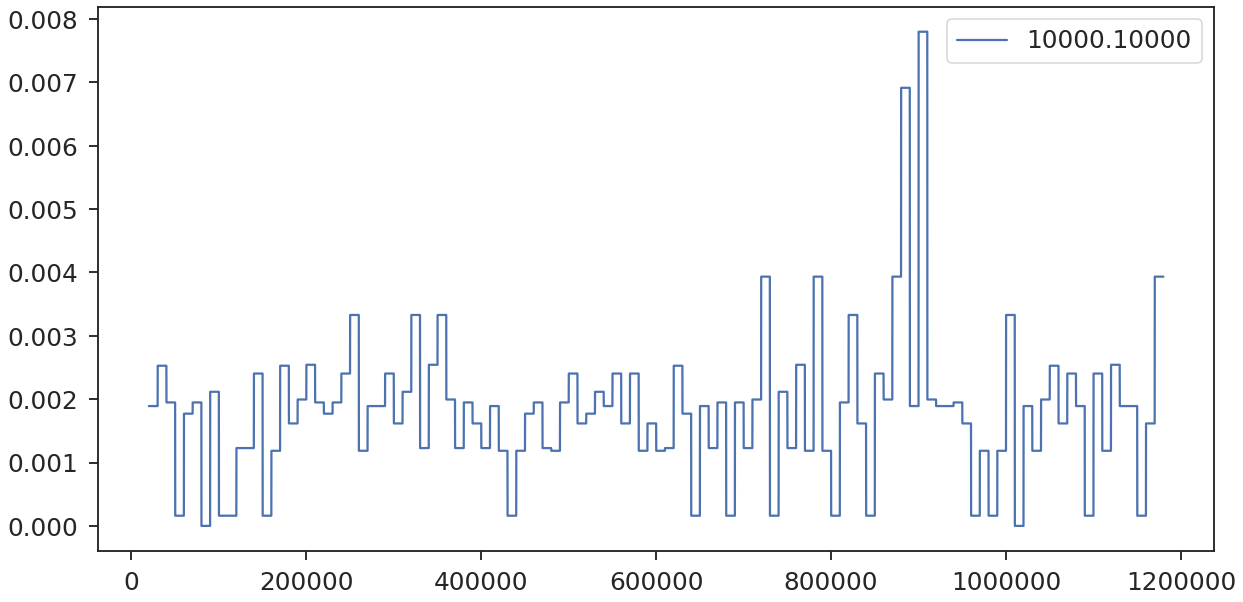

In [640]:
shift_data["0.10000"].plot([shift_data["10000.10000"]])

/home/dsuo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


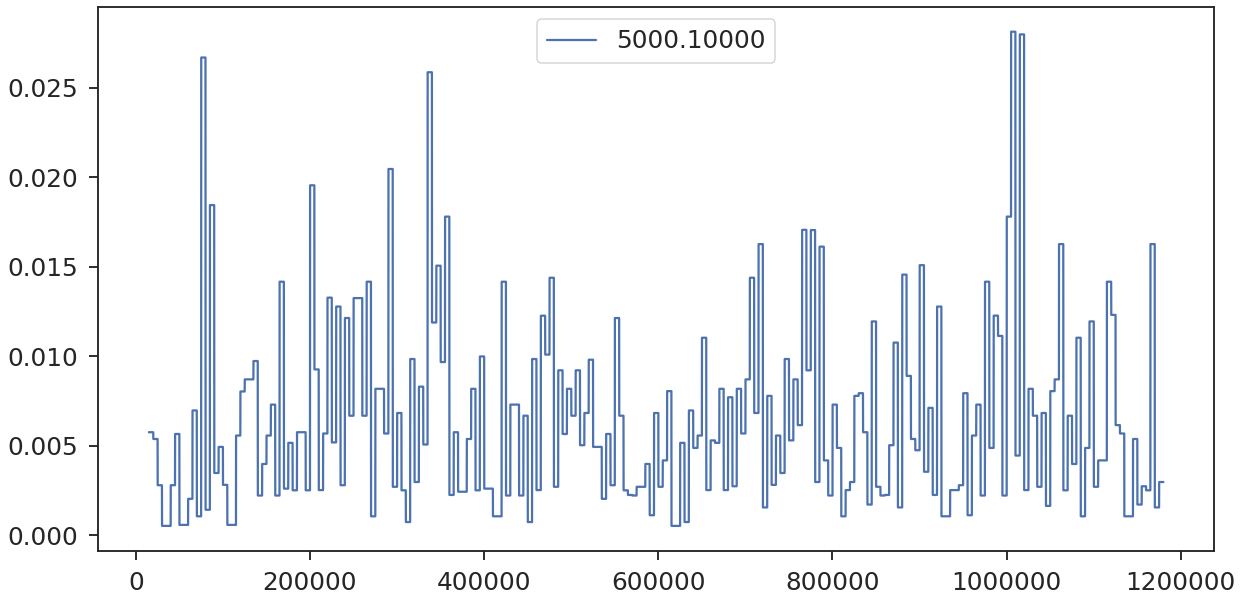

In [641]:
shift_data["0.10000"].plot([shift_data["5000.10000"]])

/home/dsuo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


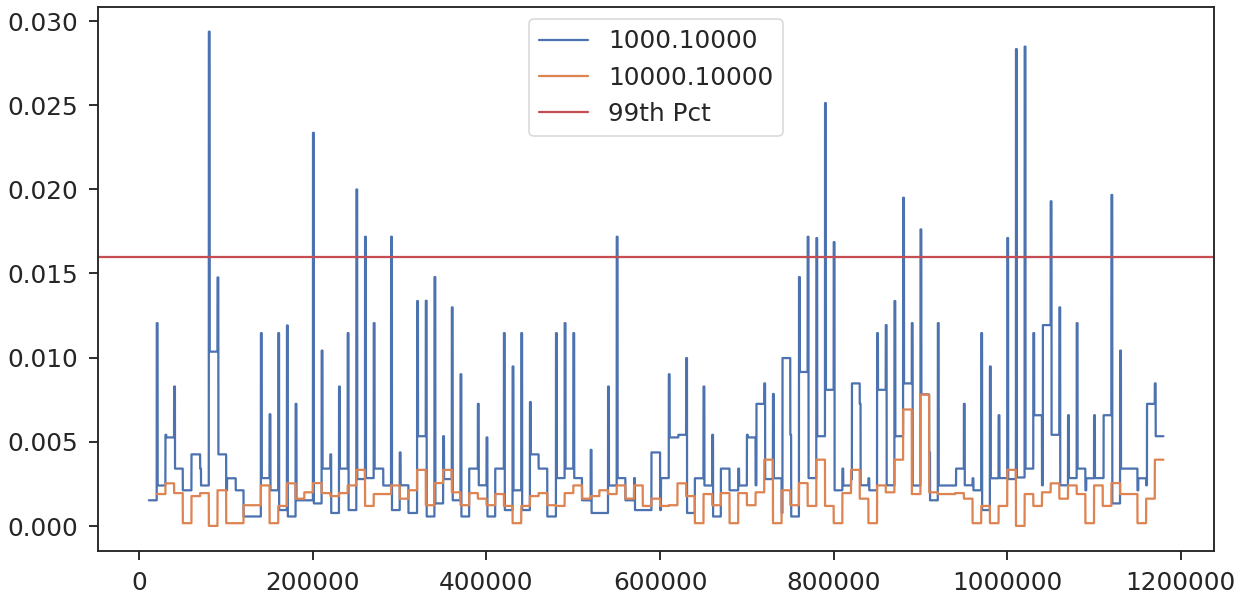

In [732]:
shift_data["0.10000"].plot([shift_data["1000.10000"], shift_data["10000.10000"]])
plt.axhline(0.016, color="r", label="99th Pct")
plt.legend()

In [647]:
shift_distance_data = {}
shift_distance_data["10000"] = pd.DataFrame(index=np.arange(0, 11000, 1000), columns=["distance"])
for i in np.arange(0, 11000, 1000):
    print(i)
    distance_df = shift_data["0.10000"].distance(shift_data["{}.10000".format(i)])
    shift_distance_data["10000"].distance.loc[i] = distance_df.distance.mean()
    

0


/home/dsuo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


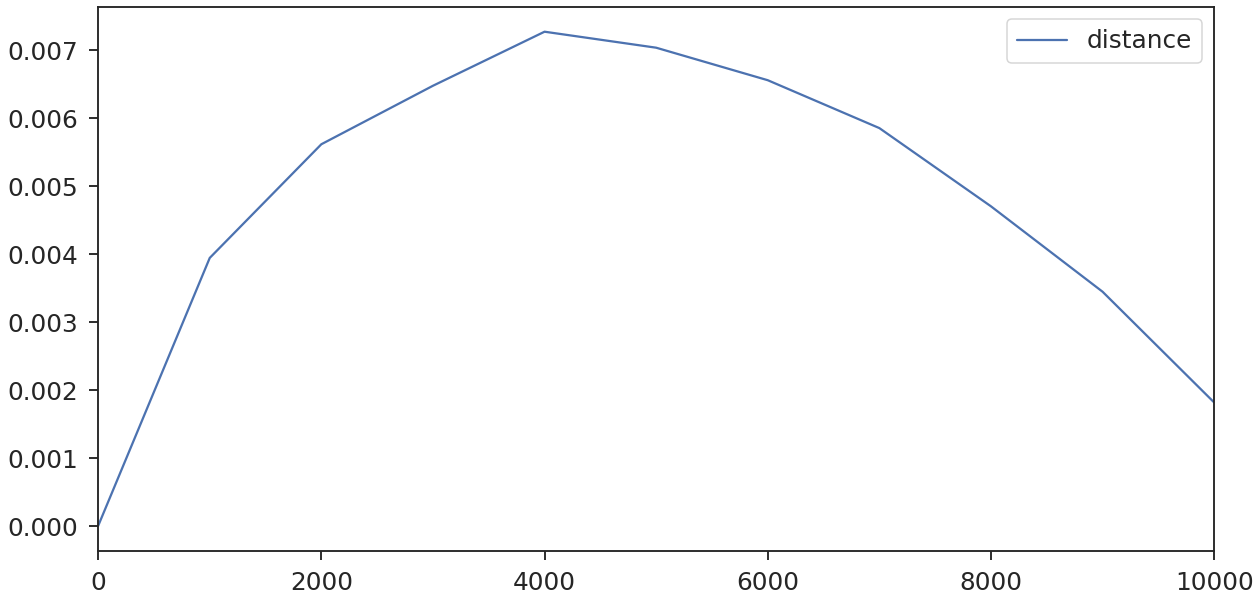

In [648]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
shift_distance_data["10000"].plot(ax=ax)

In [649]:
for i in np.arange(0, 1100, 100):
    shift = i
    scale = 1000
    name = "{}.{}".format(shift, scale)
    print("Loading {}".format(name))
    shift_data[name] = SimPoint("500.perlbench_r.1", "../tmp/bbv/{}".format(name), shift=shift, scale=scale)

Loading 0.1000
/home/dsuo/libphase/tmp/bbv/0.1000
Loading 100.1000
/home/dsuo/libphase/tmp/bbv/100.1000
Loading 200.1000
/home/dsuo/libphase/tmp/bbv/200.1000
Loading 300.1000
/home/dsuo/libphase/tmp/bbv/300.1000
Loading 400.1000
/home/dsuo/libphase/tmp/bbv/400.1000
Loading 500.1000
/home/dsuo/libphase/tmp/bbv/500.1000
Loading 600.1000
/home/dsuo/libphase/tmp/bbv/600.1000
Loading 700.1000
/home/dsuo/libphase/tmp/bbv/700.1000
Loading 800.1000
/home/dsuo/libphase/tmp/bbv/800.1000
Loading 900.1000
/home/dsuo/libphase/tmp/bbv/900.1000
Loading 1000.1000
/home/dsuo/libphase/tmp/bbv/1000.1000


/home/dsuo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


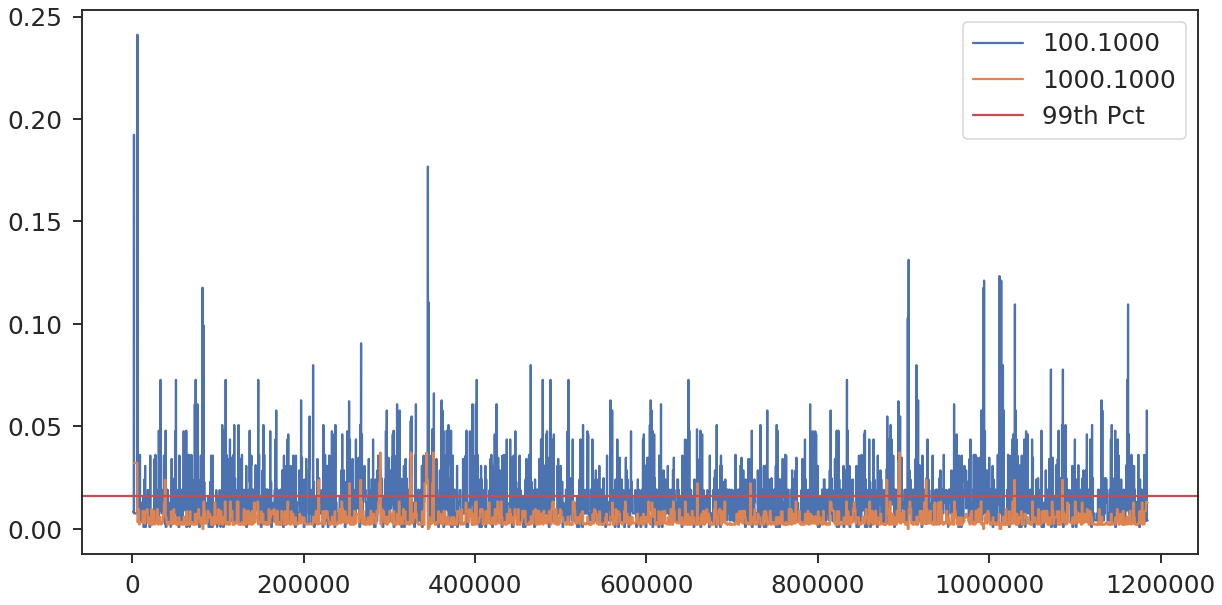

In [731]:
shift_data["0.1000"].plot([shift_data["100.1000"], shift_data["1000.1000"]])
plt.axhline(0.016, color="r", label="99th Pct")
plt.legend()

In [455]:
scale_data = {}
for i in np.power(10, np.arange(0, 5)):
    shift = 0
    scale = i
    name = "{}.{}".format(shift, scale)
    print("Loading {}".format(name))
    scale_data[name] = SimPoint("500.perlbench_r.1", "../tmp/bbv/{}".format(name), shift=shift, scale=scale)

Loading 0.1
/home/dsuo/libphase/tmp/bbv/0.1
Loading 0.10
/home/dsuo/libphase/tmp/bbv/0.10
Loading 0.100
/home/dsuo/libphase/tmp/bbv/0.100
Loading 0.1000
/home/dsuo/libphase/tmp/bbv/0.1000
Loading 0.10000
/home/dsuo/libphase/tmp/bbv/0.10000


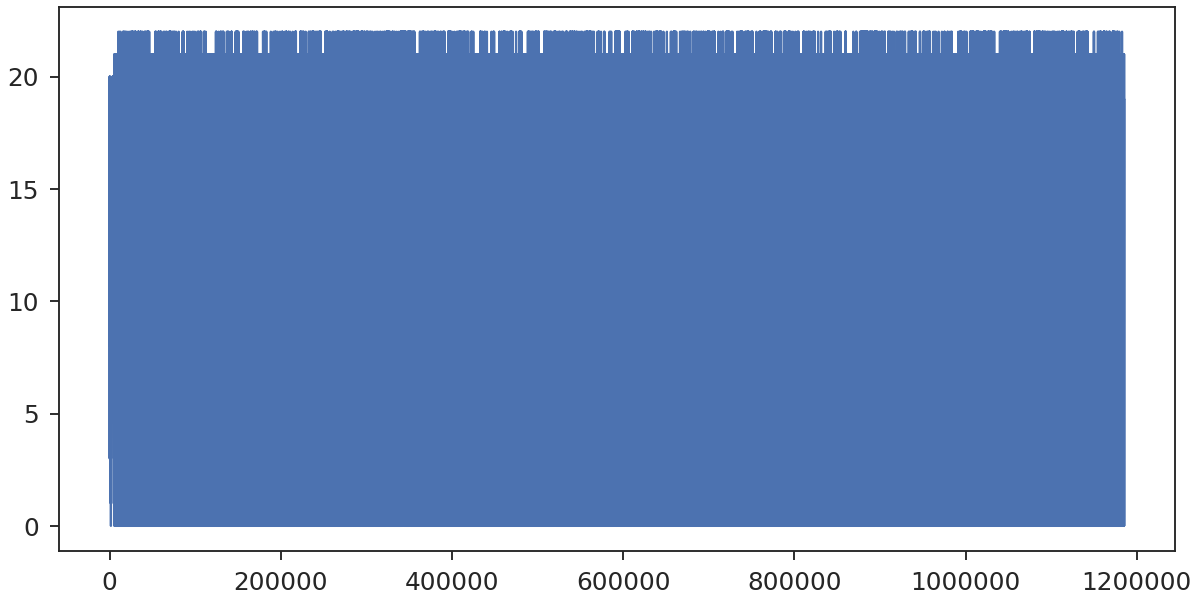

In [458]:
scale_data["0.1"].plot()

/home/dsuo/miniconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/dsuo/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


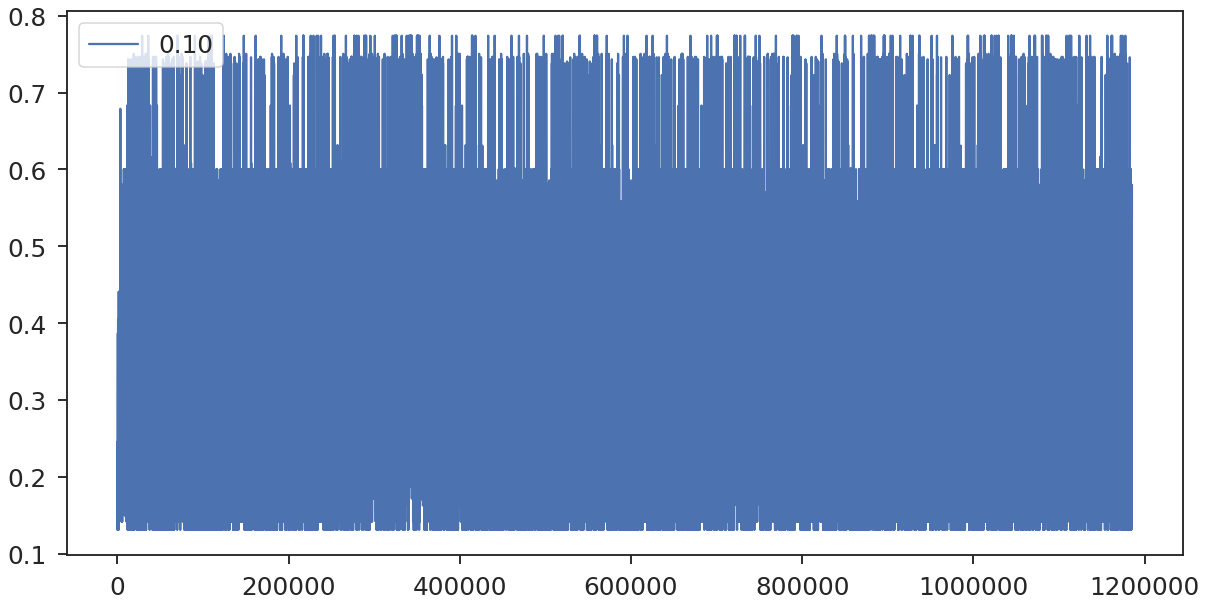

In [359]:
scale_data["0.1"].plot([scale_data["0.10"]])

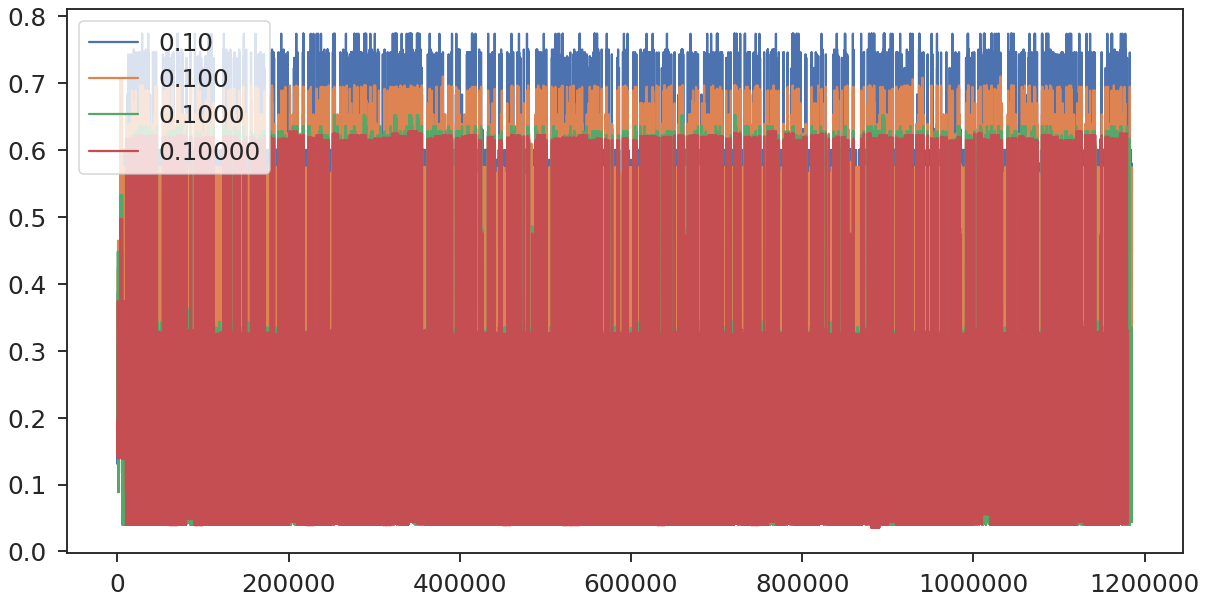

In [459]:
scale_data["0.1"].plot([scale_data["0.10"], scale_data["0.100"], scale_data["0.1000"], scale_data["0.10000"]])

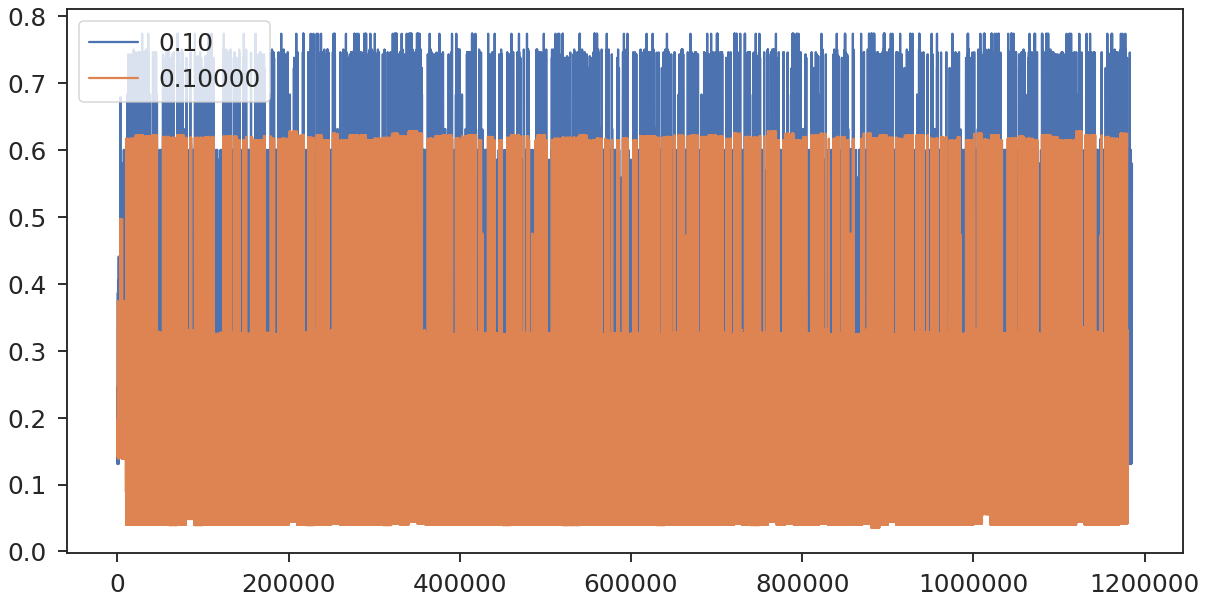

In [460]:
scale_data["0.1"].plot([scale_data["0.10"], scale_data["0.10000"]])

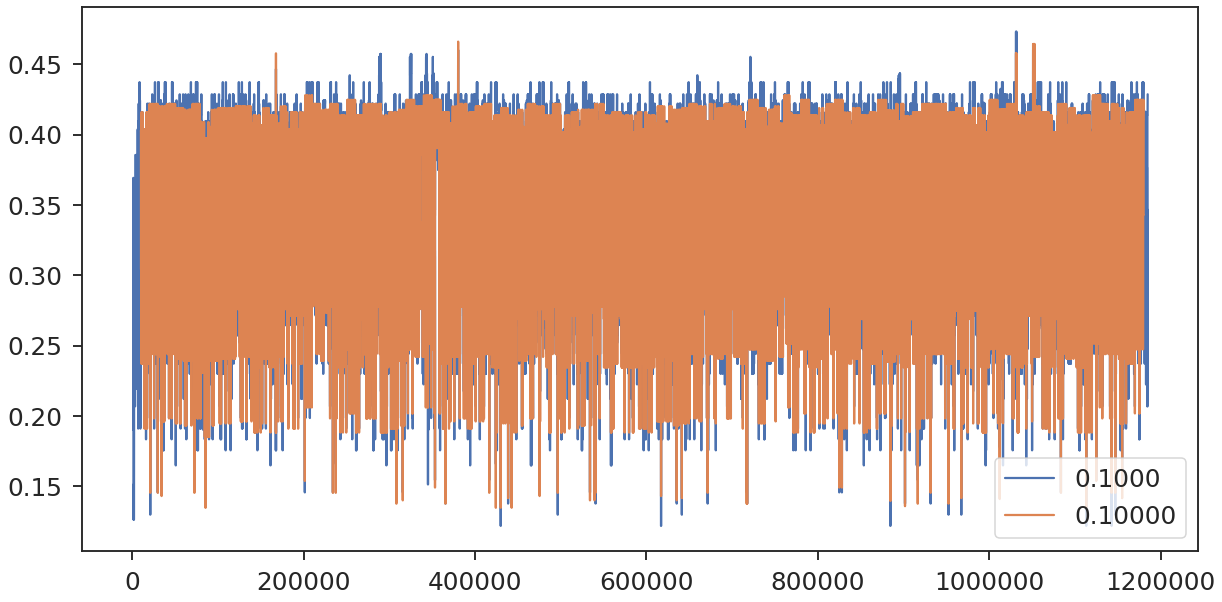

In [443]:
scale_data["0.100"].plot([scale_data["0.1000"], scale_data["0.10000"]])

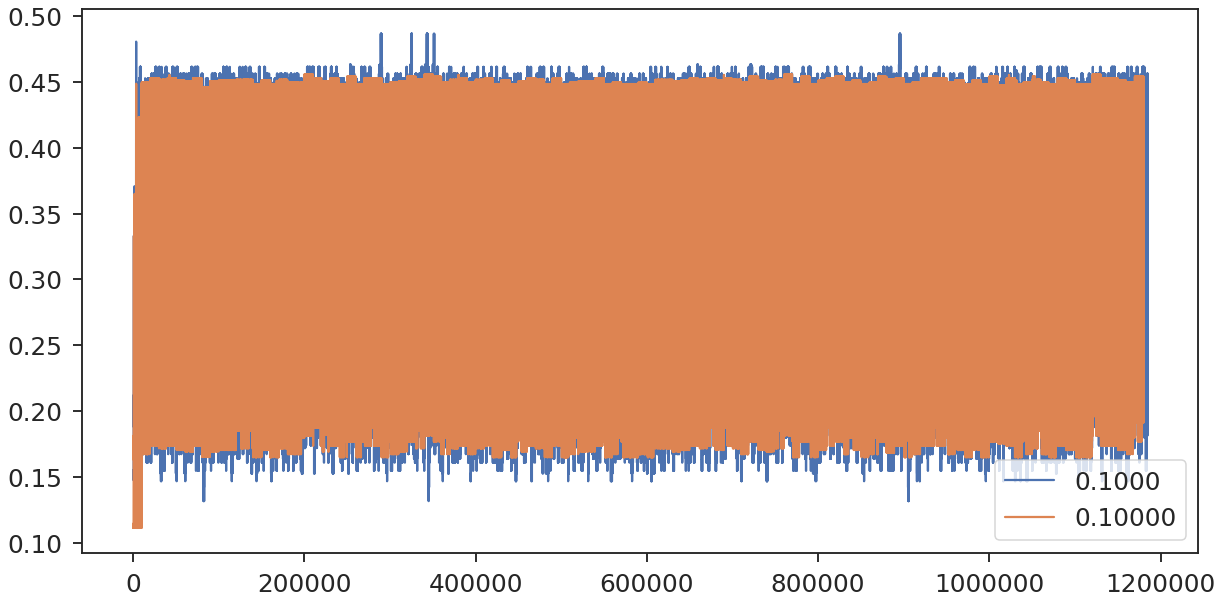

In [461]:
scale_data["0.10"].plot([scale_data["0.1000"], scale_data["0.10000"]])

In [650]:
shift_distance_data["1000"] = pd.DataFrame(index=np.arange(0, 1100, 100), columns=["distance"])
for i in np.arange(0, 1100, 100):
    print(i)
    distance_df = shift_data["0.1000"].distance(shift_data["{}.1000".format(i)])
    shift_distance_data["1000"].distance.loc[i] = distance_df.distance.mean()
    

0


/home/dsuo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


100
200
300
400
500
600
700
800
900
1000


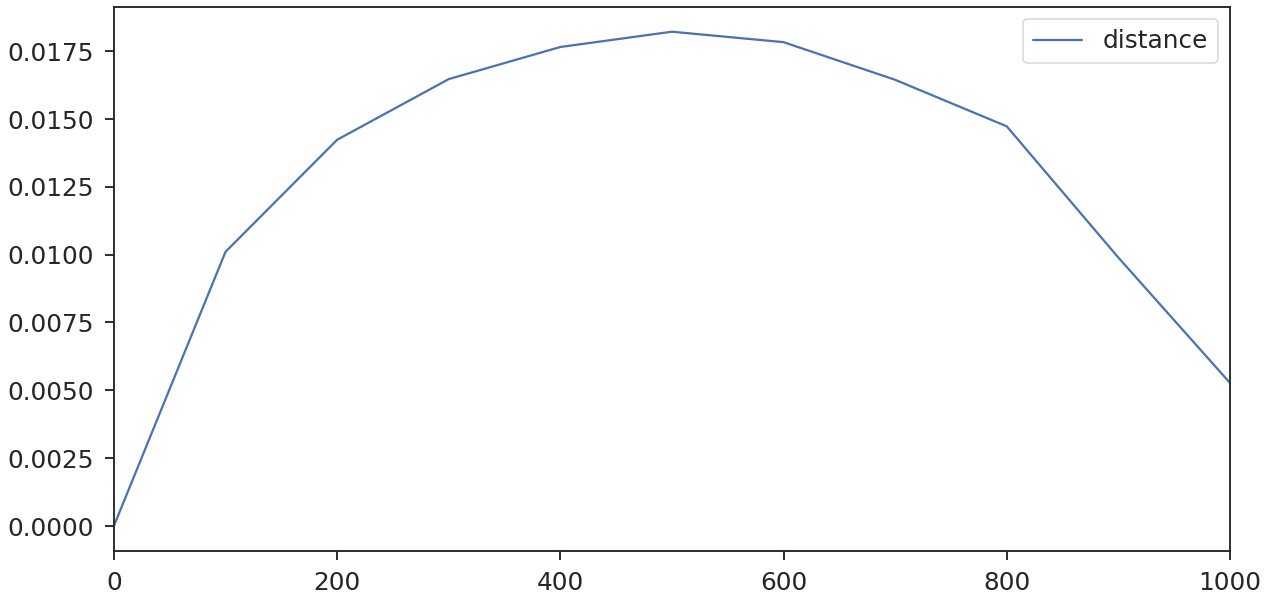

In [651]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
shift_distance_data["1000"].plot(ax=ax)

In [703]:
for i in np.arange(0, 110, 10):
    shift = i
    scale = 100
    name = "{}.{}".format(shift, scale)
    print("Loading {}".format(name))
    shift_data[name] = SimPoint("500.perlbench_r.1", "../tmp/bbv/{}".format(name), shift=shift, scale=scale)

Loading 0.100
/home/dsuo/libphase/tmp/bbv/0.100
Loading 10.100
/home/dsuo/libphase/tmp/bbv/10.100
Loading 20.100
/home/dsuo/libphase/tmp/bbv/20.100
Loading 30.100
/home/dsuo/libphase/tmp/bbv/30.100
Loading 40.100
/home/dsuo/libphase/tmp/bbv/40.100
Loading 50.100
/home/dsuo/libphase/tmp/bbv/50.100
Loading 60.100
/home/dsuo/libphase/tmp/bbv/60.100
Loading 70.100
/home/dsuo/libphase/tmp/bbv/70.100
Loading 80.100
/home/dsuo/libphase/tmp/bbv/80.100
Loading 90.100
/home/dsuo/libphase/tmp/bbv/90.100
Loading 100.100
/home/dsuo/libphase/tmp/bbv/100.100


In [704]:
shift_distance_data["100"] = pd.DataFrame(index=np.arange(0, 110, 10), columns=["distance"])
for i in np.arange(0, 110, 10):
    print(i)
    distance_df = shift_data["0.100"].distance(shift_data["{}.100".format(i)])
    shift_distance_data["100"].distance.loc[i] = distance_df.distance.mean()
    

0


/home/dsuo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


10
20
30
40
50
60
70
80
90
100


In [714]:
shift_distance_data["100"]

,distance
0,0
10,0.348952
20,0.348975
30,0.349034
40,0.348985
50,0.348906
60,0.348887
70,0.348969
80,0.348824
90,0.348947


/home/dsuo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dsuo/miniconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/dsuo/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


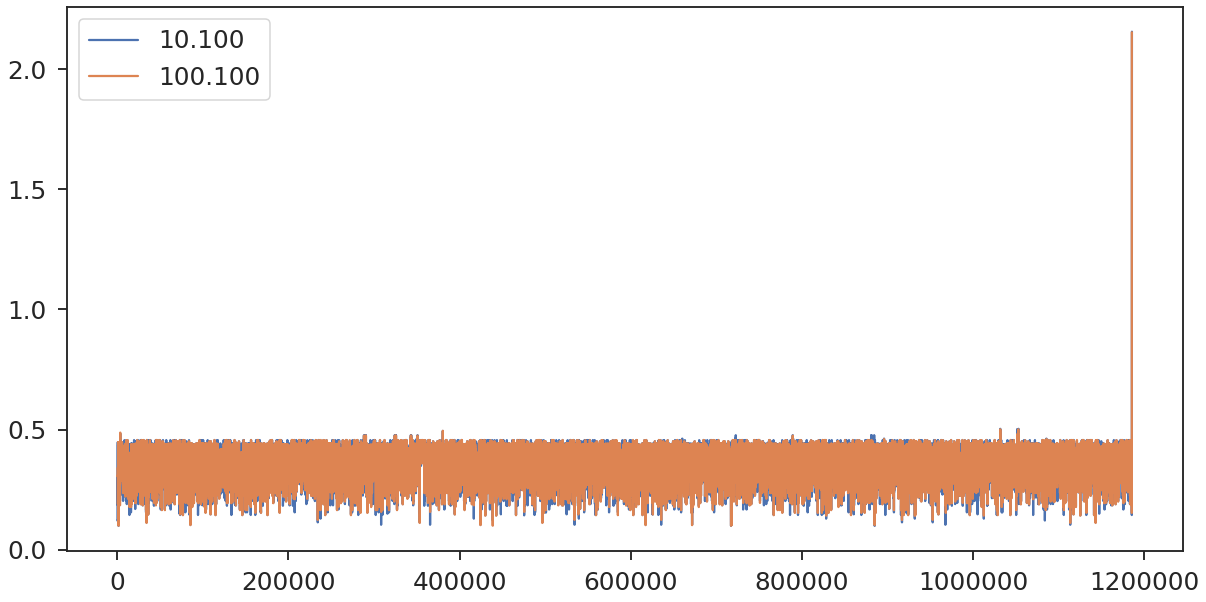

In [728]:
shift_data["0.100"].plot([shift_data["10.100"], shift_data["100.100"]])

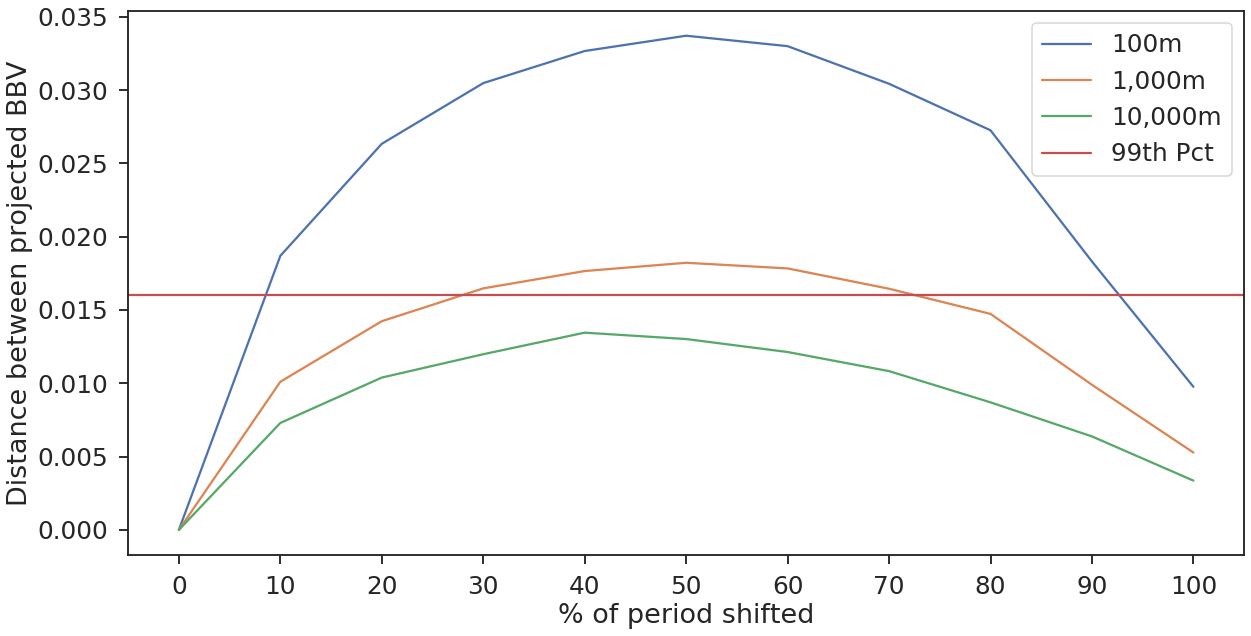

In [729]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
shift_distance_data["100"] = shift_distance_data["100"].set_index(np.linspace(0, 100, 11))
shift_distance_data["1000"] = shift_distance_data["1000"].set_index(np.linspace(0, 100, 11))
shift_distance_data["10000"] = shift_distance_data["10000"].set_index(np.linspace(0, 100, 11))
# shift_distance_data["100"].plot(ax=ax, label="100")
plt.plot(shift_distance_data["1000"].index, shift_distance_data["1000"].distance * 1.85, label="100m")
plt.plot(shift_distance_data["1000"].index, shift_distance_data["1000"].distance, label="1,000m")
plt.plot(shift_distance_data["10000"].index, shift_distance_data["10000"].distance * 1.85, label="10,000m")
# shift_distance_data["1000"].plot(ax=ax, label="1000")
# shift_distance_data["10000"].plot(ax=ax, label="10000")
plt.ylabel("Distance between projected BBV")
plt.xlabel("% of period shifted")
plt.xticks(np.linspace(0, 100, 11))
plt.axhline(0.016, color="r", label="99th Pct")
plt.legend()

In [716]:
shift_distance_data["1000"].plot(ax=ax, label="1000")
shift_distance_data["10000"]

,distance
0,0
1000,0.00394241
2000,0.00561476
3000,0.00647516
4000,0.00727031
5000,0.00703506
6000,0.00655671
7000,0.00585235
8000,0.00470165
9000,0.00344529


/home/dsuo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


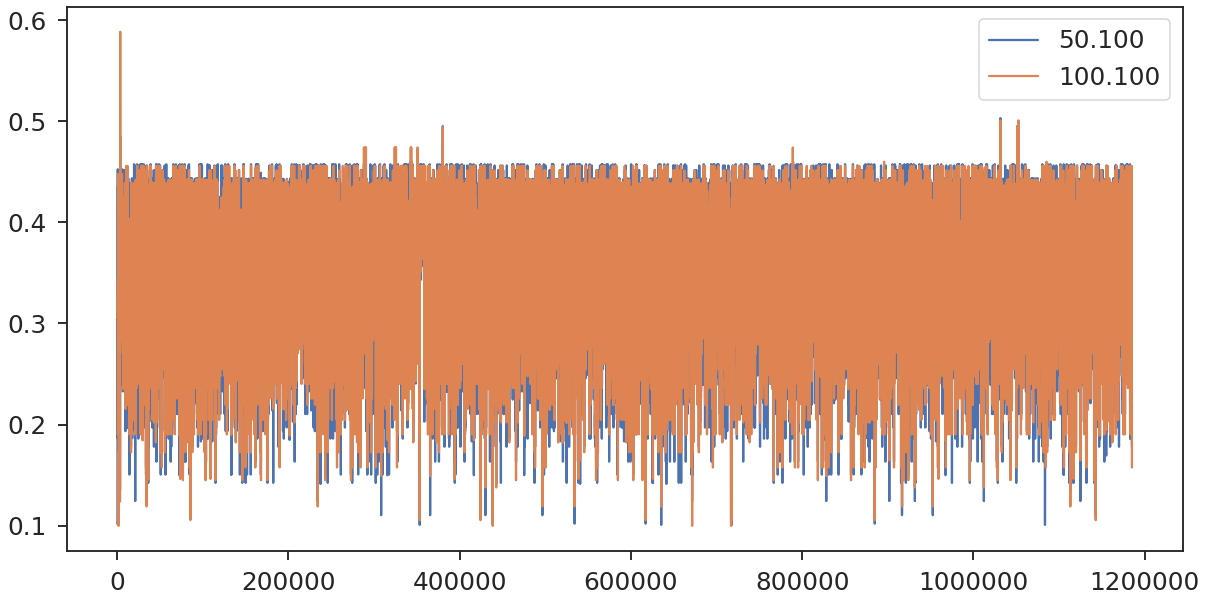

In [597]:
shift_data["0.100"].plot([shift_data["50.100"], shift_data["100.100"]])

In [402]:
max_val = 0
for i in range(100000000):
    if i % 1000000 == 0:
        print(i)
    a, b = np.random.rand(14), np.random.rand(14)
    a, b = a / a.sum(), b / b.sum()
    d = np.sqrt(np.square(a - b).sum())
    if d > max_val:
        max_val = d

0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000
48000000
49000000
50000000
51000000
52000000
53000000
54000000
55000000
56000000
57000000
58000000
59000000
60000000
61000000
62000000
63000000
64000000
65000000
66000000
67000000
68000000
69000000
70000000
71000000
72000000
73000000
74000000
75000000
76000000
77000000
78000000
79000000
80000000
81000000
82000000
83000000
84000000
85000000
86000000
87000000
88000000
89000000
90000000
91000000
92000000
93000000
94000000
95000000
96000000
97000000
98000000
99000000


In [602]:
simpoint('../tmp/bbv/500.perlbench_r.1.0.100.bbv', None, 30, None, True, "{}.{}".format(0, 100), True, True, False, None)

{'bbv_file': '../tmp/bbv/500.perlbench_r.1.0.100.bbv', 'k': None, 'max_k': 30, 'proj_matrix': None, 'variable_length': True, 'output_dir': '0.100', 'save_proj_matrix': True, 'verbose': True, 'quiet': False, 'args': None}
/home/dsuo/libphase/tmp/bbv/0.100
Command:  /home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.0.100.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/0.100/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/0.100/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/0.100/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/0.100/out.labels -saveVectorsTxtFmt /home/dsuo/libphase/tmp/bbv/0.100/out.vectors -saveProjMatrixTxtFmt /home/dsuo/libphase/tmp/bbv/0.100/out.proj_matrix -k search -maxK 30 -fixedLength off
Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.0.100.bbv -saveSimpoints /h

(b'Command-line: "/home/dsuo/libphase/build/deps/simpoint/simpoint-git-prefix/src/simpoint-git/bin/simpoint -loadFVFile ../tmp/bbv/500.perlbench_r.1.0.100.bbv -saveSimpoints /home/dsuo/libphase/tmp/bbv/0.100/out.simpoints -saveSimpointWeights /home/dsuo/libphase/tmp/bbv/0.100/out.weights -saveFinalCtrs /home/dsuo/libphase/tmp/bbv/0.100/out.centres -saveLabels /home/dsuo/libphase/tmp/bbv/0.100/out.labels -saveVectorsTxtFmt /home/dsuo/libphase/tmp/bbv/0.100/out.vectors -saveProjMatrixTxtFmt /home/dsuo/libphase/tmp/bbv/0.100/out.proj_matrix -k search -maxK 30 -fixedLength off"\nUsing these options (*** indicates user-specified option):\n*** -loadFVFile : ../tmp/bbv/500.perlbench_r.1.0.100.bbv\n*** -k : search\n    -iters : 100\n    -dim : 15\n*** -maxK : 30\n    -numInitSeeds : 5\n    -coveragePct : 1\n    -bicThreshold : 0.9\n    -saveAll : false\n    -initkm : samp\n*** -saveLabels : /home/dsuo/libphase/tmp/bbv/0.100/out.labels\n*** -saveSimpoints : /home/dsuo/libphase/tmp/bbv/0.100/out

In [609]:
shift_data_vli = {}
for i in np.arange(0, 1100, 100):
    if i == 200:
        continue
    shift = i
    scale = 1000
    name = "{}.{}".format(shift, scale)
    print("Loading {}".format(name))
    shift_data_vli[name] = SimPoint("500.perlbench_r.1", "../tmp/bbv/{}.vli".format(name), shift=shift, scale=scale)

Loading 0.1000
/home/dsuo/libphase/tmp/bbv/0.1000.vli
Loading 100.1000
/home/dsuo/libphase/tmp/bbv/100.1000.vli
Loading 300.1000
/home/dsuo/libphase/tmp/bbv/300.1000.vli
Loading 400.1000
/home/dsuo/libphase/tmp/bbv/400.1000.vli
Loading 500.1000
/home/dsuo/libphase/tmp/bbv/500.1000.vli
Loading 600.1000
/home/dsuo/libphase/tmp/bbv/600.1000.vli
Loading 700.1000
/home/dsuo/libphase/tmp/bbv/700.1000.vli
Loading 800.1000
/home/dsuo/libphase/tmp/bbv/800.1000.vli
Loading 900.1000
/home/dsuo/libphase/tmp/bbv/900.1000.vli
Loading 1000.1000
/home/dsuo/libphase/tmp/bbv/1000.1000.vli


/home/dsuo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dsuo/miniconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/dsuo/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


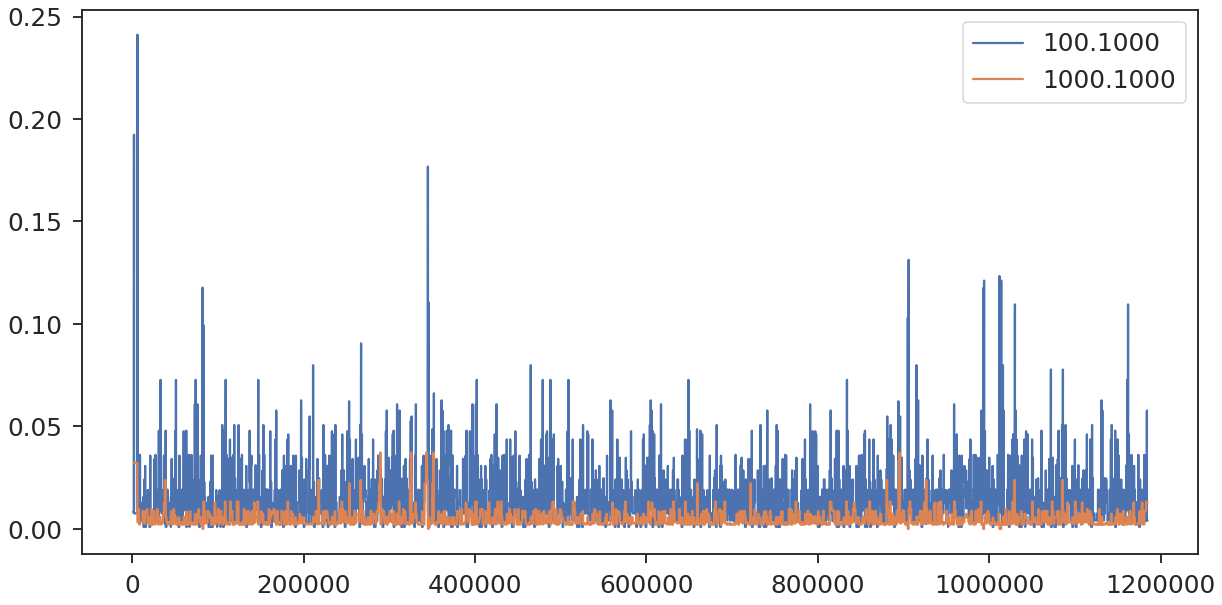

In [610]:
shift_data_vli["0.1000"].plot([shift_data_vli["100.1000"], shift_data_vli["1000.1000"]])